# Przygotowanie danych pod Machine Learning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from unidecode import unidecode
import re

### Wczytujemy dataset merged_datasets.csv (~100k rekordów)

In [2]:
mails = pd.read_csv('merged_datasets.csv')
categories = pd.CategoricalDtype(['safe', 'phishing'], ordered=True)
mails['label'] = mails['label'].astype(categories)

### Usuwamy duplikaty i usuwamy wiersze, w których <b>body</b> lub <b>nadawca</b> są puste

In [3]:
mails.drop_duplicates(subset=['subject', 'sender_mail'], keep='first', inplace=True)
mails.dropna(subset=['body', 'sender_mail'], inplace=True)

## Tworzymy kolumny, który pomogą rozpoznawać phishing

### Wyciągamy <b>URLe</b> z <b>body</b> wiadomości e-mail i liczymy ich ilość

In [4]:
def extract_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    matches = re.findall(url_pattern, text)

    return matches, len(matches)


mails[['extracted_urls', 'urls_count']] = mails['body'].apply(lambda x: pd.Series(extract_urls(x)))

def map_url_lens(lens):
    if lens <= 2:
        return str(lens)
    else:
        return '3<='


mails['urls_count'] = mails['urls_count'].apply(map_url_lens)
categories = pd.CategoricalDtype(['0', '1', '2', '3<='], ordered=True)
mails['urls_count'] = mails['urls_count'].astype(categories)

### Losujemy (dla czystego sumienia) jeden <b>URL</b> z uzyskanej listy (zakładamy, że jeżeli jeden URL w wiadomości jest phishingiem, to inne też)

In [5]:
# Jeżeli jeden url w mailu jest fałszywy, to wychodzimy z założenia, że inne też
def return_random_url(urls):
    urls_len = len(urls)
    if urls_len == 0:
        return None

    random_index = np.random.randint(0, urls_len)
    randomized_url = urls[random_index]
    return randomized_url

mails['in_body_url'] = mails['extracted_urls'].apply(return_random_url)

### Usuwamy rekordy, które nie zawierają żadnych <b>URLi</b>, są nam zbędne i tylko utrudniają życie

In [6]:
print(mails.shape)
mails.dropna(subset=['in_body_url'], inplace=True)
print(mails.shape)
print(mails.label.value_counts(normalize=True))

(87633, 8)
(41716, 8)
label
phishing    0.614944
safe        0.385056
Name: proportion, dtype: float64


<hr>
87 633 - 41 716 = <b>45 917</b></br>
Tyle wierszy poszło z dymem.</br>
Z pozostałych wierszy:
<ul>
    <li>61.5% stanowi <b><i>phishing</i></b></li>
    <li>38.5% stanowią <b><i>bezpieczne wiersze</i></b></li>
</ul>
<hr>

### Wyciągamy z <b>URLi</b> protokoły: <b><i>HTTP</i></b> i <b><i>HTTPS</i></b>

In [7]:
def is_https(url):
    protocol = url[:5].lower()
    return 'https' if protocol == 'https' else 'http'


mails['protocol'] = mails['in_body_url'].apply(is_https)
categories = pd.CategoricalDtype(['http', 'https'], ordered=True)
mails['protocol'] = mails['protocol'].astype(categories)

### Sprawdzamy, czy <b>URLe</b> zawierają <b><i>IP</i></b>

In [8]:
def contains_ip(url):
    ip_pattern = re.compile(r'\b(?:\d{1,3}\.){3}\d{1,3}\b|\b(?:[0-9a-fA-F]{1,4}:){7}[0-9a-fA-F]{1,4}\b')
    ips = ip_pattern.findall(url)

    if ips:
        return True
    else:
        return False


mails['contains_ip'] = mails['in_body_url'].apply(contains_ip)
print(mails['contains_ip'].value_counts())

contains_ip
False    41567
True       149
Name: count, dtype: int64


### Pobieramy długość <b>URLi</b>

In [9]:
mails['url_length'] = mails['in_body_url'].apply(len)

### Wyciągamy z <b>URLi</b> <b><i>domenę</i></b>

In [10]:
'''
POPRAWIĆ! nie ucina czasem domeny poprawnie

'''

def get_domain(url):
    pattern = re.compile(r'https?://([^/?]+)')
    match = pattern.match(url)
    if match:
        domain = match.group(1)
        if '/' in domain:
            return domain.split('/')[0]
        
        return domain
    else:
        return url


mails['domain'] = mails['in_body_url'].apply(get_domain)

### Wyciągamy z <b>domeny</b> <b><i>TLD</i></b> (top-level domain)
ue.poznan.<font color="cyan"><b>pl</b></font></br>
www.vaticannews.<font color="cyan"><b>va</b></font>

In [11]:
def get_TLD(domain):
    split_domain = domain.split('.')
    n = len(split_domain)
    delimiters = ['/', ':', ')', ']', '%', '_', '=', ',', '>', '"', '#', '!']
    # Check if not weird ending
    after_dot = split_domain[n-1]
    if len(after_dot) > 2 and not after_dot.isalpha():
        after_dot = after_dot.split('/')[0]
        
        if len(after_dot) > 2 and not after_dot.isalpha():
            print(after_dot, 'INSIDE')
            for delimiter in delimiters:
                after_dot = " ".join(after_dot.split(delimiter))
            
            after_dot = after_dot.split()[0]

    TLD = '.'+after_dot.lower()
    return TLD


mails['TLD'] = mails['domain'].apply(get_TLD)

gm$ INSIDE
177 INSIDE
edu:11371 INSIDE
org:8010 INSIDE
localhost:8880 INSIDE
com", INSIDE
org:8010 INSIDE
org:8010 INSIDE
org:8010 INSIDE
org:8010 INSIDE
tv", INSIDE
org) INSIDE
cc, INSIDE
com) INSIDE
com", INSIDE
domainname:80, INSIDE
org), INSIDE
org) INSIDE
org:8011 INSIDE
nz&mt_ref=RET_1_Wine_Sale INSIDE
com)) INSIDE
bspace-dev-01 INSIDE
org) INSIDE
org) INSIDE
com! INSIDE
com, INSIDE
nz) INSIDE
http: INSIDE
localhost:631 INSIDE
ie: INSIDE
ie: INSIDE
1:631 INSIDE
org) INSIDE
org, INSIDE
132 INSIDE
132 INSIDE
132 INSIDE
132 INSIDE
132 INSIDE
132 INSIDE
htm) INSIDE
edu:8080 INSIDE
net:8000 INSIDE
1:631 INSIDE
uk; INSIDE
com) INSIDE
net:8000 INSIDE
com) INSIDE
com, INSIDE
com) INSIDE
164 INSIDE
com"}) INSIDE
com"}) INSIDE
com, INSIDE
com), INSIDE
at) INSIDE
com), INSIDE
cz), INSIDE
net) INSIDE
html#ComleyDowe2005 INSIDE
ie), INSIDE
ie) INSIDE
com) INSIDE
org, INSIDE
org): INSIDE
org) INSIDE
org) INSIDE
http: INSIDE
http: INSIDE
org" INSIDE
be) INSIDE
localhost:8082 INSIDE
org) INSIDE


### Sprawdzamy, czy <b>TLD</b> zawiera tylko litery
A nie na przykład <b>liczbę</b>, <b>adres IP</b> itd.

In [12]:
def is_tld_alpha(tld):
    return tld[1:].isalpha()


mails['TLD_alpha'] = mails['TLD'].apply(is_tld_alpha)

### Sprawdzany poziom subdomeny
wikipedia.org = 0 </br>
<font color="cyan"><b>en</b></font>.wikipedia.org = 1 </br>
...

In [13]:
def get_subdomain_level(domain):
    return domain.count('.')-1


def map_subdomain_lv(num):
    if num <= 2:
        return str(num)
    else:
        return '3<='


mails['subdomain_level'] = mails['domain'].apply(get_subdomain_level)
mails['subdomain_level'] = mails['subdomain_level'].apply(map_subdomain_lv)
categories = pd.CategoricalDtype(['0', '1', '2', '3<='], ordered=True)
mails['subdomain_level'] = mails['subdomain_level'].astype(categories)


print(mails['subdomain_level'].value_counts(normalize=True))

subdomain_level
1      0.621118
0      0.265150
2      0.101554
3<=    0.012178
Name: proportion, dtype: float64


In [14]:
# Usuwamy kolumnę, która się omyłkowo wkradła
mails.drop(mails.columns[0], axis=1, inplace=True)

### Liczymy "<b><i>/</i></b>" w <b>URL</b>ach

In [15]:
def count_slashes(url):
    return url.count('/')


def map_slashes(num):
    if num <= 5:
        return str(num)
    else:
        return '6<='



mails['slash_count'] = mails['in_body_url'].apply(count_slashes)

mails['slash_count'] = mails['slash_count'].apply(map_slashes)
categories = pd.CategoricalDtype(['0', '1', '2', '3', '4', '5', '6<='], ordered=True)
mails['slash_count'] = mails['slash_count'].astype(categories)

### Liczymy "<b><i>.</i></b>" w <b>URL</b>ach

In [16]:
def count_dots(url):
    return url.count('.')


def map_dots(num):
    if num <= 4:
        return str(num)
    else:
        return '5<='


mails['dots_count'] = mails['in_body_url'].apply(count_dots)

mails['dots_count'] = mails['dots_count'].apply(map_dots)
categories = pd.CategoricalDtype(['0', '1', '2', '3', '4', '5<='], ordered=True)
mails['dots_count'] = mails['dots_count'].astype(categories)

### Liczymy "<b><i>-</i></b>" w <b>URL</b>ach

In [17]:
def count_hyphens(url):
    return url.count('-')


def map_hyphens(num):
    if num <= 1:
        return str(num)
    else:
        return '2<='


mails['hyphens_count'] = mails['in_body_url'].apply(count_hyphens)

mails['hyphens_count'] = mails['hyphens_count'].apply(map_hyphens)
categories = pd.CategoricalDtype(['0', '1', '2<='], ordered=True)
mails['hyphens_count'] = mails['hyphens_count'].astype(categories)

### Sprawdzamy, czy w <b>URL</b>ach znajdują się litery z alfabetu innego niż <b><i>łaciński</i></b> (例 itd.)


In [18]:
def has_non_latin_chars(url):
    ascii = unidecode(url)
    return url != ascii


mails['has_non_latin'] = mails['in_body_url'].apply(has_non_latin_chars)
print(mails['has_non_latin'].value_counts(normalize=True))

print(mails.groupby('has_non_latin').label.value_counts(normalize=True))

has_non_latin
False    0.997435
True     0.002565
Name: proportion, dtype: float64
has_non_latin  label   
False          phishing    0.614338
               safe        0.385662
True           phishing    0.850467
               safe        0.149533
Name: proportion, dtype: float64


### Wizualizujemy, czy zebrane kolumny w ogóle mają jakikolwiek sens

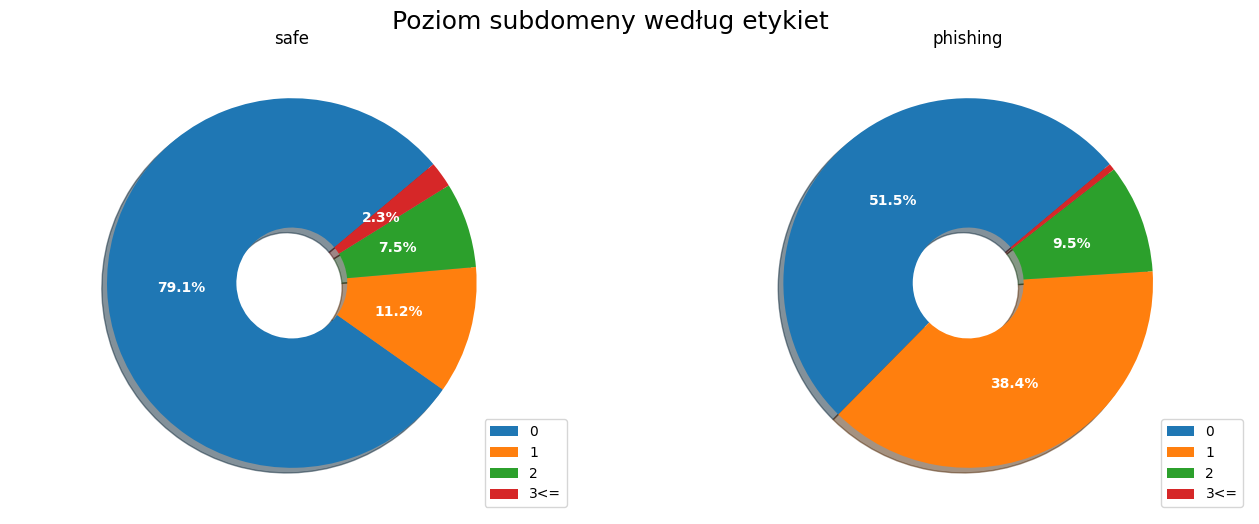

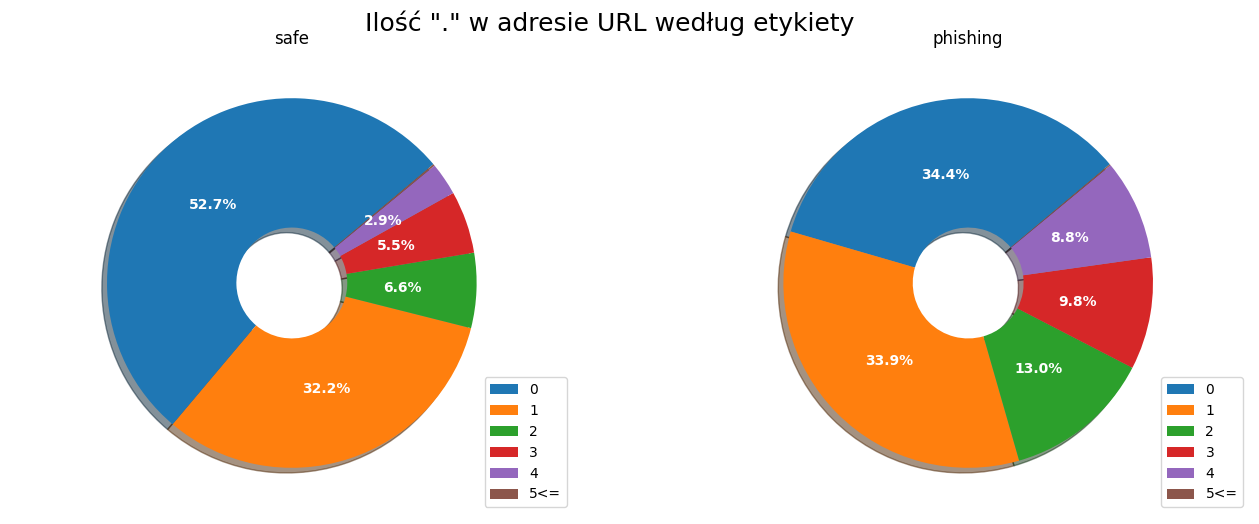

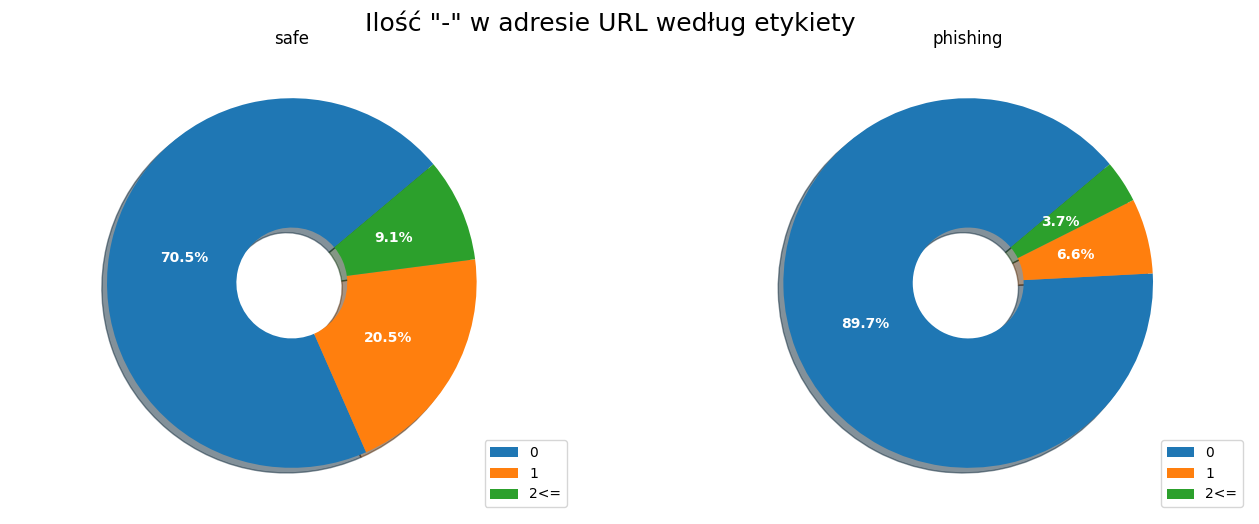

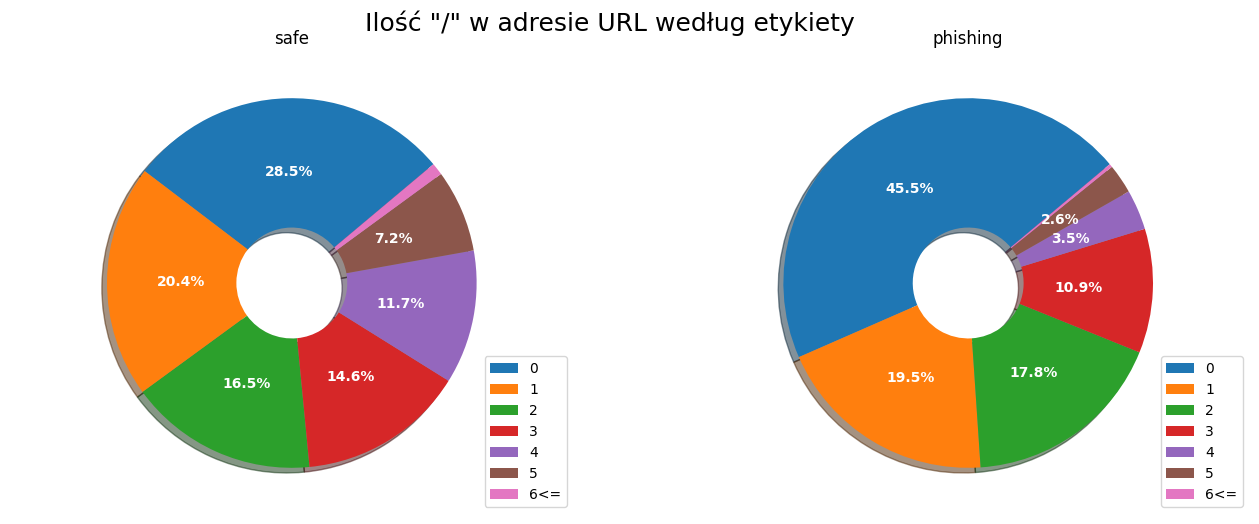

In [19]:
def make_pie_chart(col_name, chart_title=''):
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    # SAFE
    legit_rows = mails[mails['label']=='safe']
    data = legit_rows[col_name].value_counts(normalize=True).to_dict()

    labels = list(data.keys())
    values = list(data.values())
    autopct_format = lambda p: f'{p:.1f}%' if p > 2 else ''

    ax[0].axis('equal')
    ax[0].set_title('safe')

    wedges, texts, autotexts = ax[0].pie(x=values,
                                    wedgeprops=dict(width=0.70),
                                    autopct=autopct_format,
                                    shadow=True,
                                    startangle=40)

    ax[0].legend(wedges, sorted(labels), loc='lower right')
    plt.setp(autotexts, size=10, weight="bold", c='w')

    # PHISHING
    phishing_rows = mails[mails['label']=='phishing']
    data = phishing_rows[col_name].value_counts(normalize=True).to_dict()

    labels = list(data.keys())
    values = list(data.values())
    autopct_format = lambda p: f'{p:.1f}%' if p > 2 else ''

    ax[1].axis('equal')
    ax[1].set_title('phishing')

    wedges, texts, autotexts = ax[1].pie(x=values,
                                    wedgeprops=dict(width=0.70),
                                    autopct=autopct_format,
                                    shadow=True,
                                    startangle=40)

    ax[1].legend(wedges, sorted(labels), loc='lower right')
    plt.setp(autotexts, size=10, weight="bold", c='w')

    plt.suptitle(chart_title, fontsize=18, y=0.95)


what_to_visualise = {
    'subdomain_level': 'Poziom subdomeny według etykiet',
    'dots_count': 'Ilość "." w adresie URL według etykiety',
    'hyphens_count': 'Ilość "-" w adresie URL według etykiety',
    'slash_count': 'Ilość "/" w adresie URL według etykiety',
}

for k, v in what_to_visualise.items():
    make_pie_chart(k, v)

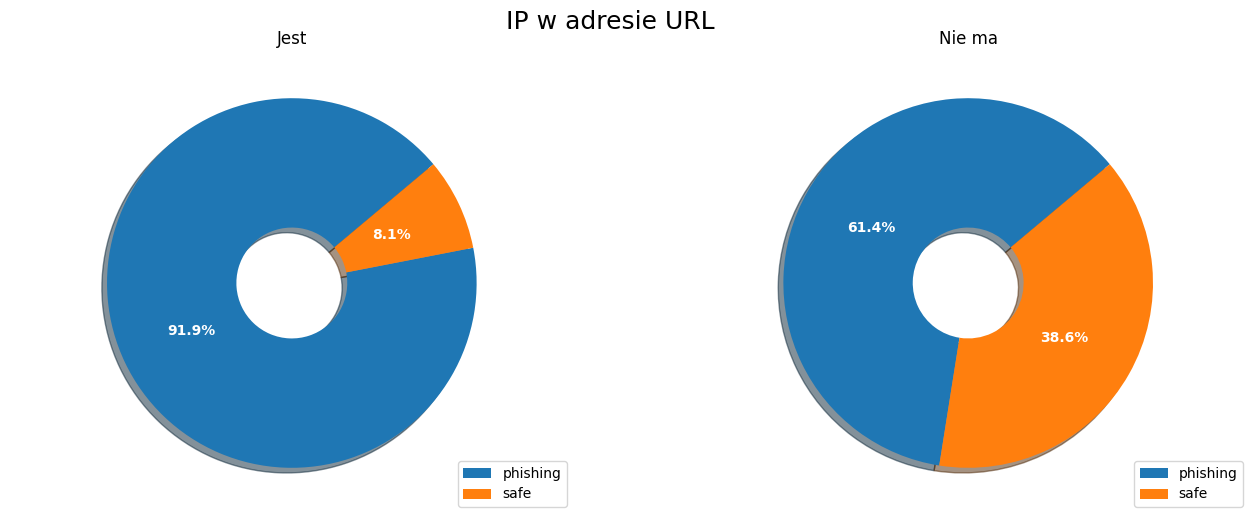

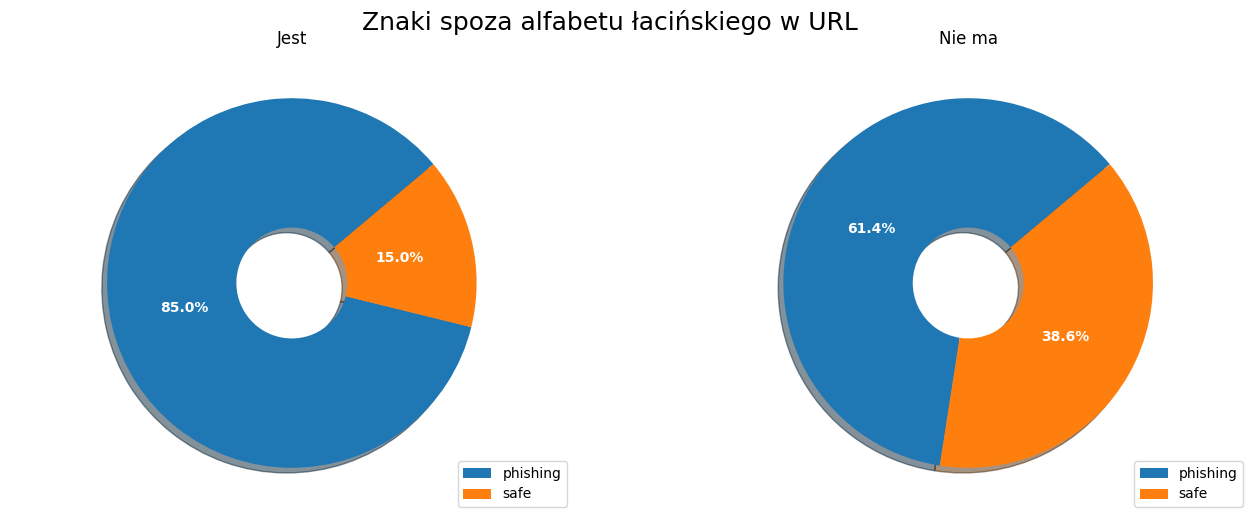

In [20]:
def make_pie_chart2(col_name, chart_title=''):
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    # SAFE
    rows = mails[mails[col_name]==True]
    data = rows['label'].value_counts(normalize=True).to_dict()

    labels = list(data.keys())
    values = list(data.values())
    autopct_format = lambda p: f'{p:.1f}%' if p > 2 else ''

    ax[0].axis('equal')
    ax[0].set_title('Jest')

    wedges, texts, autotexts = ax[0].pie(x=values,
                                    wedgeprops=dict(width=0.70),
                                    autopct=autopct_format,
                                    shadow=True,
                                    startangle=40)

    ax[0].legend(wedges, sorted(labels), loc='lower right')
    plt.setp(autotexts, size=10, weight="bold", c='w')

    # PHISHING
    rows = mails[mails[col_name]==False]
    data = rows['label'].value_counts(normalize=True).to_dict()

    labels = list(data.keys())
    values = list(data.values())
    autopct_format = lambda p: f'{p:.1f}%' if p > 2 else ''

    ax[1].axis('equal')
    ax[1].set_title('Nie ma')

    wedges, texts, autotexts = ax[1].pie(x=values,
                                    wedgeprops=dict(width=0.70),
                                    autopct=autopct_format,
                                    shadow=True,
                                    startangle=40)

    ax[1].legend(wedges, sorted(labels), loc='lower right')
    plt.setp(autotexts, size=10, weight="bold", c='w')

    plt.suptitle(chart_title, fontsize=18, y=0.95)


what_to_visualise = {
    'contains_ip': 'IP w adresie URL',
    'has_non_latin': 'Znaki spoza alfabetu łacińskiego w URL'
}

for k, v in what_to_visualise.items():
    make_pie_chart2(k, v)

### Tak.

# Przygotowanie pod ML

In [21]:
print(mails.head(1))

       sender_mail                    subject  \
0  Young@iworld.de  Never agree to be a loser   

                                                body     label  \
0  Buck up, your troubles caused by small dimensi...  phishing   

            extracted_urls urls_count            in_body_url protocol  \
0  [http://whitedone.com/]          1  http://whitedone.com/     http   

   contains_ip  url_length         domain   TLD  TLD_alpha subdomain_level  \
0        False          21  whitedone.com  .com       True               0   

  slash_count dots_count hyphens_count  has_non_latin  
0           3          1             0          False  


### Zamiana kolejności [y | x<sub>i</sub>] (dla wygody)

In [22]:
mails_ML = mails[['label', 'urls_count', 'protocol', 'contains_ip', 'url_length', 'TLD_alpha', 'subdomain_level', 'slash_count', 'dots_count', 'hyphens_count', 'has_non_latin']]
print(mails_ML.head())

      label urls_count protocol  contains_ip  url_length  TLD_alpha  \
0  phishing          1     http        False          21       True   
1  phishing          1     http        False          25       True   
2  phishing        3<=     http        False          97       True   
3      safe        3<=     http        False          22      False   
4  phishing          1     http        False         136       True   

  subdomain_level slash_count dots_count hyphens_count  has_non_latin  
0               0           3          1             0          False  
1               1           2          2             0          False  
2               1         6<=        5<=             0          False  
3               1           2          2             0          False  
4               2           4          4           2<=          False  


### Mapowanie wartości z <b>categories/object (stringi)</b> na <b>int</b>

In [23]:
label_map = {
    'safe': 0,
    'phishing': 1
}

urls_count_map = {
    '1': 1,
    '2': 2,
    '3<=': 3,
}

protocol_map = {
    'https': 1,
    'http': 0
}

contains_ip_map = {
    True: 1,
    False: 0
}

TLD_alpha_map = {
    True: 1,
    False: 0
}

subdomain_level = {
    '0': 0,
    '1': 1,
    '2': 2,
    '3<=': 3
}

slash_count_map = {
    '0': 0,
    '1': 1,
    '2': 2,
    '3': 3,
    '4': 4,
    '5': 5,
    '6<=': 6,
}

dots_count_map = {
    '0': 0,
    '1': 1,
    '2': 2,
    '3': 3,
    '4': 4,
    '5<=': 5,
}

hyphens_count_map = {
    '0': 0,
    '1': 1,
    '2<=': 2,
}

has_non_latin_map = {
    True: 1,
    False: 0
}

mails_ML.loc[:, 'label'] = mails_ML['label'].map(label_map)
mails_ML.loc[:, 'urls_count'] = mails_ML['urls_count'].map(urls_count_map)
mails_ML.loc[:, 'protocol'] = mails_ML['protocol'].map(protocol_map)
mails_ML.loc[:, 'contains_ip'] = mails_ML['contains_ip'].map(contains_ip_map)
mails_ML.loc[:, 'TLD_alpha'] = mails_ML['TLD_alpha'].map(TLD_alpha_map)
mails_ML.loc[:, 'subdomain_level'] = mails_ML['subdomain_level'].map(subdomain_level)
mails_ML.loc[:, 'slash_count'] = mails_ML['slash_count'].map(slash_count_map)
mails_ML.loc[:, 'dots_count'] = mails_ML['dots_count'].map(dots_count_map)
mails_ML.loc[:, 'hyphens_count'] = mails_ML['hyphens_count'].map(hyphens_count_map)
mails_ML.loc[:, 'has_non_latin'] = mails_ML['has_non_latin'].map(has_non_latin_map)
mails_ML = mails_ML.astype(float)
print(mails_ML.head())

   label  urls_count  protocol  contains_ip  url_length  TLD_alpha  \
0    1.0         1.0       0.0          0.0        21.0        1.0   
1    1.0         1.0       0.0          0.0        25.0        1.0   
2    1.0         3.0       0.0          0.0        97.0        1.0   
3    0.0         3.0       0.0          0.0        22.0        0.0   
4    1.0         1.0       0.0          0.0       136.0        1.0   

   subdomain_level  slash_count  dots_count  hyphens_count  has_non_latin  
0              0.0          3.0         1.0            0.0            0.0  
1              1.0          2.0         2.0            0.0            0.0  
2              1.0          6.0         5.0            0.0            0.0  
3              1.0          2.0         2.0            0.0            0.0  
4              2.0          4.0         4.0            2.0            0.0  


### Zapisujemy rezultat do .csv

In [24]:
mails_ML.to_csv('ML_DataFrame.csv')